In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from time import time
import math
import os
import types

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
from utils3d.PDE_Model import PDE_Model
from utils3d.PDE_Model import PDE_Model_2
from utils3d.Preconditioner import Preconditioner
from utils3d.Preconditioner import change_fun

from utils3d.Mesh import Mesh
from utils3d.NeuralNet import PINN_NeuralNet

from utils3d.PINN import PINN
from utils3d.Postprocessing import View_results
from utils3d.PINN import PINN_Precond

from utils3d.XPINN import XPINN
from utils3d.Postprocessing import View_results_X


## PINN

Se resolverá:
$$\nabla^2 u = \frac{1}{\epsilon} \delta(r)$$
$$ 0 <r <1$$
Solución analítica:
$$ u(r) = \frac{1}{4\pi\epsilon r} $$

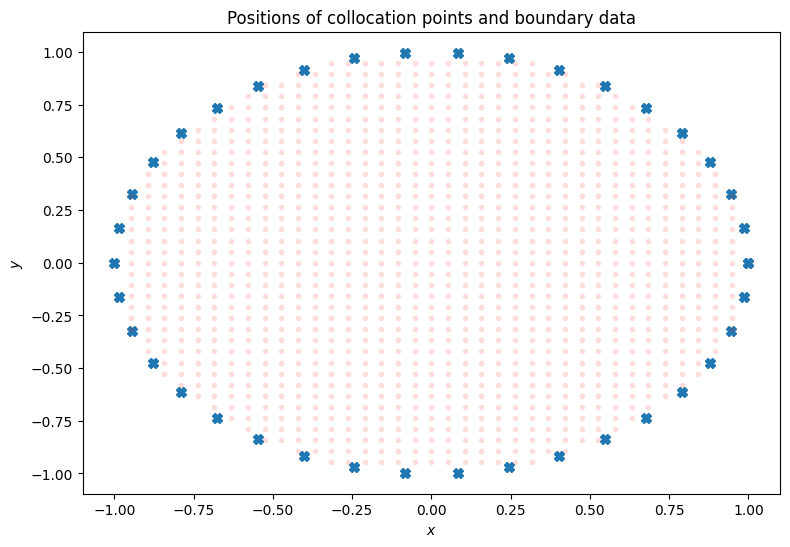

In [3]:
domain1 = ([-1,1],[-1,1],[-1,1])
PDE1 = PDE_Model()
domain1 = PDE1.set_domain(domain1)
PDE1.sigma = 0.04
PDE1.epsilon = 1

lb = {'type':'D', 'value':-1/(4*np.pi*PDE1.epsilon), 'fun':None, 'dr':None, 'r':1}
borders = {'1':lb}
ins_domain = {'rmax': 1}

mesh1 = Mesh(domain1, N_b=60, N_r=1500)
mesh1.create_mesh(borders, ins_domain)
mesh1.plot_points_2d();


PINN_solver = PINN()

PINN_solver.adapt_PDE(PDE1)
weights = {
        'w_r': 1,
        'w_d': 1,
        'w_n': 1,
        'w_i': 1
}
PINN_solver.adapt_mesh(mesh1,**weights)

lr = ([2500,4000],[1e-2,5e-3,5e-4])
hyperparameters = {
        'input_shape': (None,3),
        'num_hidden_layers': 8,
        'num_neurons_per_layer': 20,
        'output_dim': 1,
        'activation': 'tanh'
}

PINN_solver.create_NeuralNet(PINN_NeuralNet,lr,**hyperparameters)

In [4]:
PINN_solver.model.summary()

Model: "pinn__neural_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             multiple                  0         
                                                                 
 dense (Dense)               multiple                  80        
                                                                 
 dense_1 (Dense)             multiple                  420       
                                                                 
 dense_2 (Dense)             multiple                  420       
                                                                 
 dense_3 (Dense)             multiple                  420       
                                                                 
 dense_4 (Dense)             multiple                  420       
                                                                 
 dense_5 (Dense)             multiple             

In [5]:
PINN_solver.solve(N=1500)

Loss: 1.30177826e-01: 100%|██████████| 1500/1500 [14:59<00:00,  1.67it/s]



Computation time: 899.7086997032166 seconds


In [6]:

PINN_solver.save_model('.saved_models','Test_pinn_3d') 

In [7]:
Post = View_results(PINN_solver)

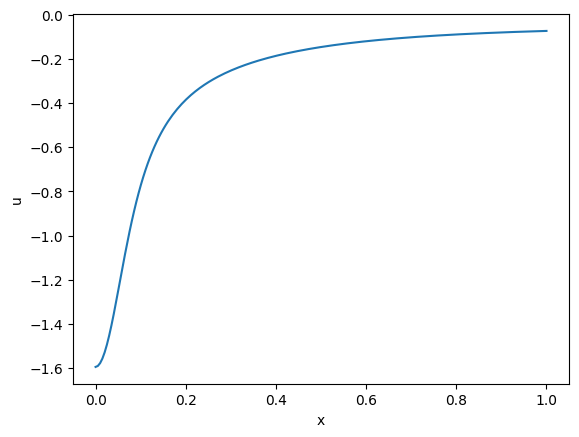

In [8]:
Post.plot_u_plane();

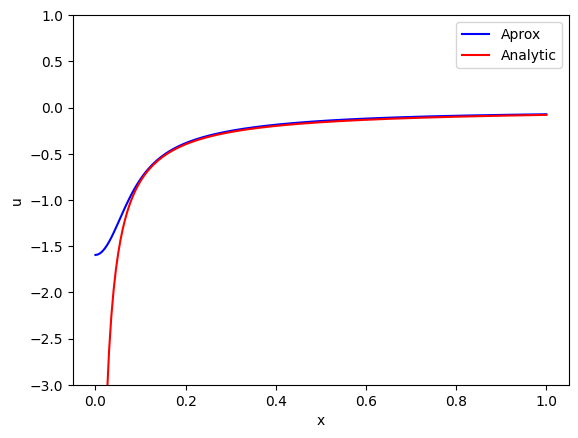

In [9]:
Post.plot_aprox_analytic()

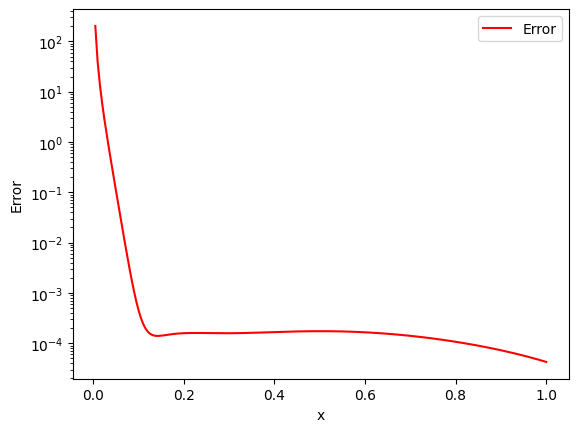

In [11]:
Post.plot_loss_analytic();

<AxesSubplot: xlabel='$n_{epoch}$', ylabel='$\\phi^{n_{epoch}}$'>

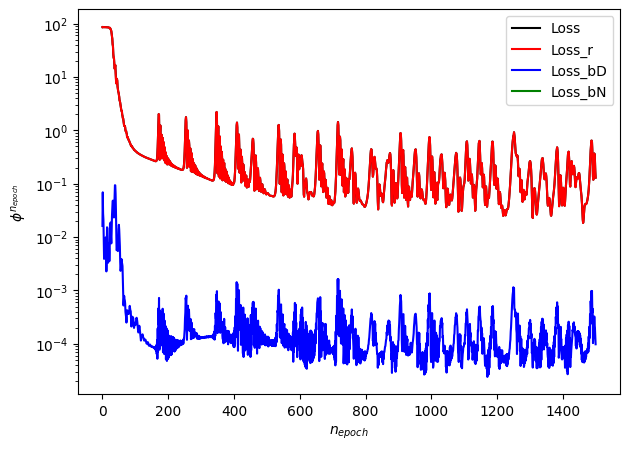

In [10]:
Post.plot_loss_history()

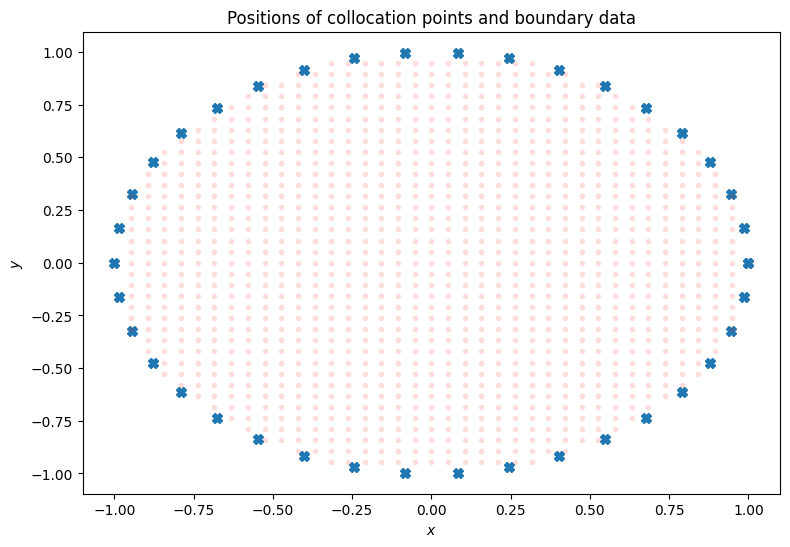

In [3]:
domain1 = ([-1,1],[-1,1],[-1,1])
PDE1 = PDE_Model()
domain1 = PDE1.set_domain(domain1)
PDE1.sigma = 0.04
PDE1.epsilon = 1

lb = {'type':'D', 'value':-1/(4*np.pi), 'fun':None, 'dr':None, 'r':1}
borders = {'1':lb}
ins_domain = {'rmax': 1}

mesh1 = Mesh(domain1, N_b=60, N_r=1500)
mesh1.create_mesh(borders, ins_domain)
mesh1.plot_points_2d();


PINN_solver = PINN()

PINN_solver.adapt_PDE(PDE1)
weights = {
        'w_r': 1,
        'w_d': 1,
        'w_n': 1,
        'w_i': 1
}
PINN_solver.adapt_mesh(mesh1,**weights)

lr = ([2500,4000],[1e-2,5e-3,5e-4])
hyperparameters = {
        'input_shape': (None,3),
        'num_hidden_layers': 8,
        'num_neurons_per_layer': 20,
        'output_dim': 1,
        'activation': 'tanh'
}


PINN_solver.load_NeuralNet('.saved_models','Test_pinn_3d',lr)

In [4]:
Post = View_results(PINN_solver)

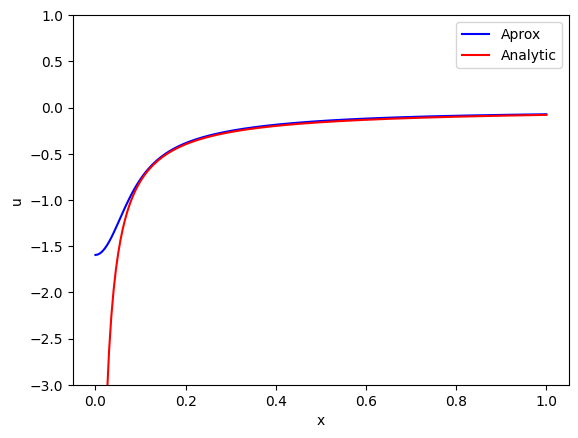

In [5]:
Post.plot_aprox_analytic()

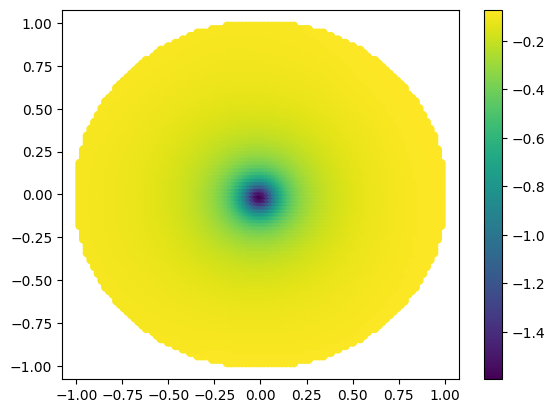

In [6]:
Post.plot_u_domain_contour()

In [8]:
Post.plot_u_domain_surface(N=400)

## XPINN

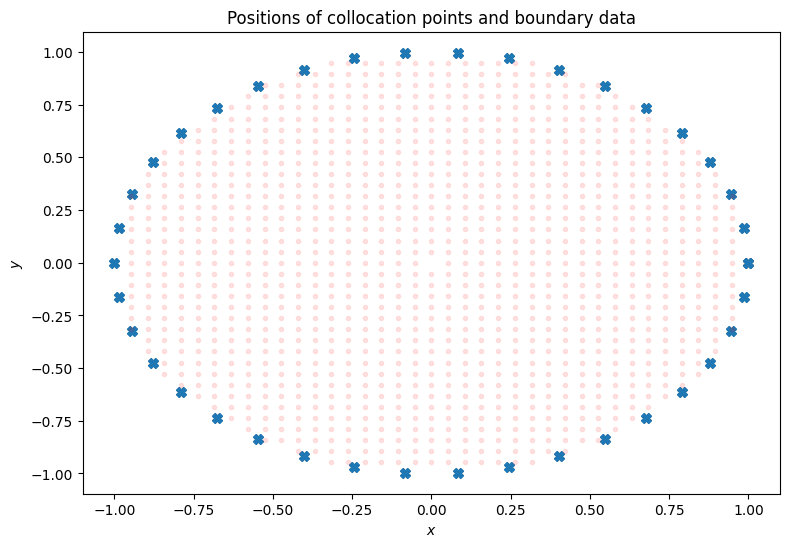

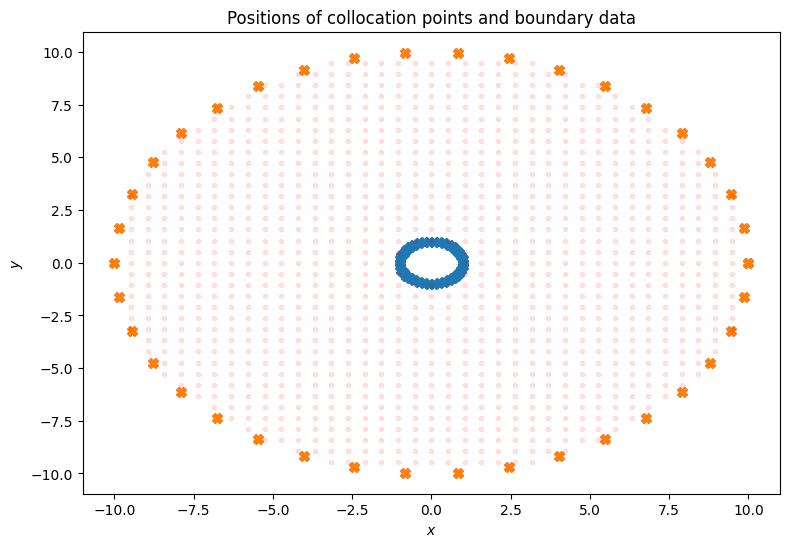

In [9]:
domain1 = ([-1,1],[-1,1],[-1,1])
PDE1 = PDE_Model()
domain1 = PDE1.set_domain(domain1)
PDE1.sigma = 0.04
PDE1.epsilon = 1

lb = {'type':'I', 'value':None, 'fun':None, 'dr':None, 'r':1}
borders = {'1':lb}
ins_domain = {'rmax': 1, 'rmin':0}

mesh1 = Mesh(domain1, N_b=60, N_r=1500)
mesh1.create_mesh(borders, ins_domain)
mesh1.plot_points_2d();

PDE2 = PDE_Model_2()
domain2 = ([-10,10],[-10,10],[-10,10])
domain2 = PDE1.set_domain(domain2)
PDE2.sigma = 0.04
PDE2.epsilon = 1

lb = {'type':'I', 'value':None, 'fun':None, 'dr':None, 'r':1}
lb2 = {'type':'D', 'value':(1.0/(4*np.pi*PDE2.epsilon))*(1/10), 'fun':None, 'dr':None, 'r':10}
borders = {'1':lb,'2':lb2}
ins_domain = {'rmax': 10,'rmin':1}

mesh2 = Mesh(domain2, N_b=60, N_r=1500)
mesh2.create_mesh(borders, ins_domain)
mesh2.plot_points_2d();

XPINN_solver = XPINN(PINN)

XPINN_solver.adapt_PDEs([PDE1,PDE2],[1,10])
weights = {
        'w_r': 1,
        'w_d': 1,
        'w_n': 1,
        'w_i': 1
}
XPINN_solver.adapt_meshes([mesh1,mesh2],[weights,weights])

lr = ([1500,3500],[1e-2,5e-3,5e-4])
hyperparameters = {
        'input_shape': (None,3),
        'num_hidden_layers': 8,
        'num_neurons_per_layer': 20,
        'output_dim': 1,
        'activation': 'tanh'
}

XPINN_solver.create_NeuralNets(PINN_NeuralNet,[lr,lr],[hyperparameters,hyperparameters])

In [10]:
XPINN_solver.solve(N=2000)

Loss: 7.2756e-03: 100%|██████████| 2000/2000 [56:12<00:00,  1.69s/it]



Computation time: 3372.848687648773 seconds


In [11]:
Post = View_results_X(XPINN_solver,View_results)

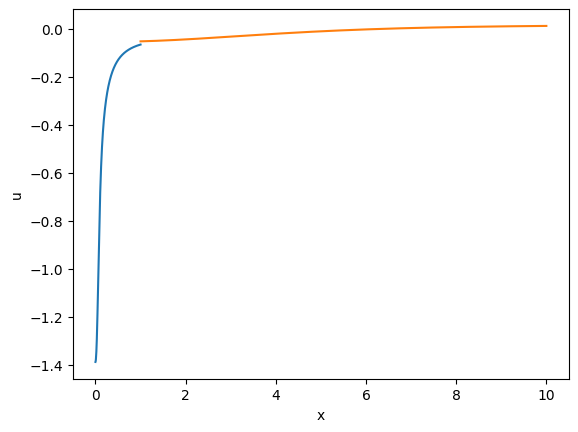

In [12]:
Post.plot_u_plane()

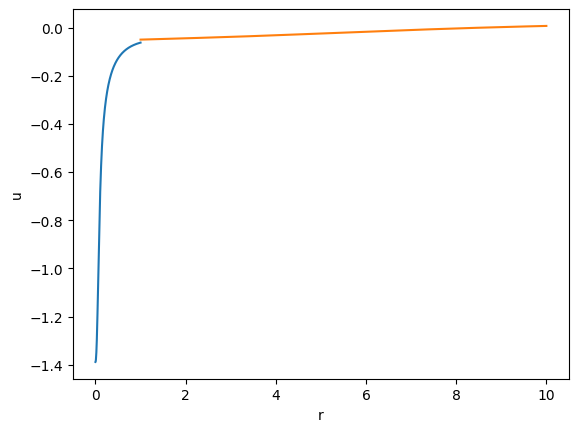

In [16]:
theta = 100.0
phi = 60.0
Post.plot_u_plane_direction(theta,phi)

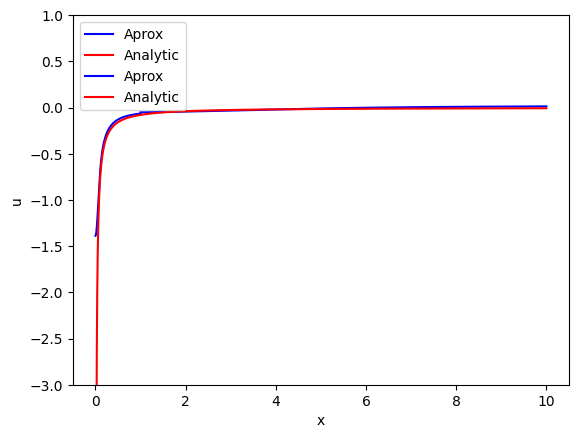

In [14]:
Post.plot_aprox_analytic()